In [2]:
import os
import glob
import IPython.display as ipd
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Subtract
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.initializers import RandomNormal

from tqdm.notebook import tqdm, trange

In [3]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [4]:
paths_all_labels = []
for image in images:
    x = image.split("d", 1)
    paths_all_labels.append((x[0], './frgc32x32/'+image))

In [5]:
import pandas as pd

In [6]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [7]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


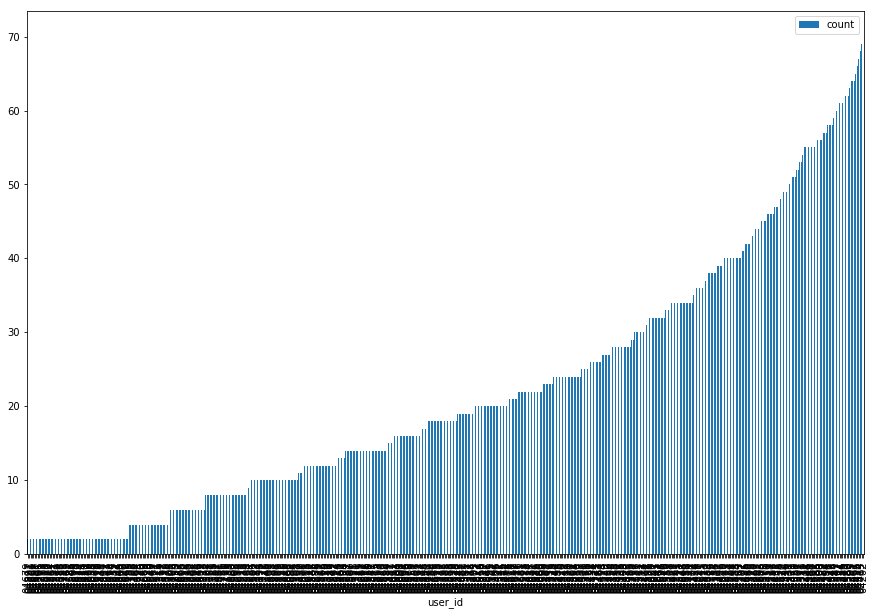

In [8]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [9]:
data_size = 20

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)
ids_to_keep = ids_to_keep[ids_to_keep].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(data_size)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

There are 265/568 (46.65%) unique IDs remaining.


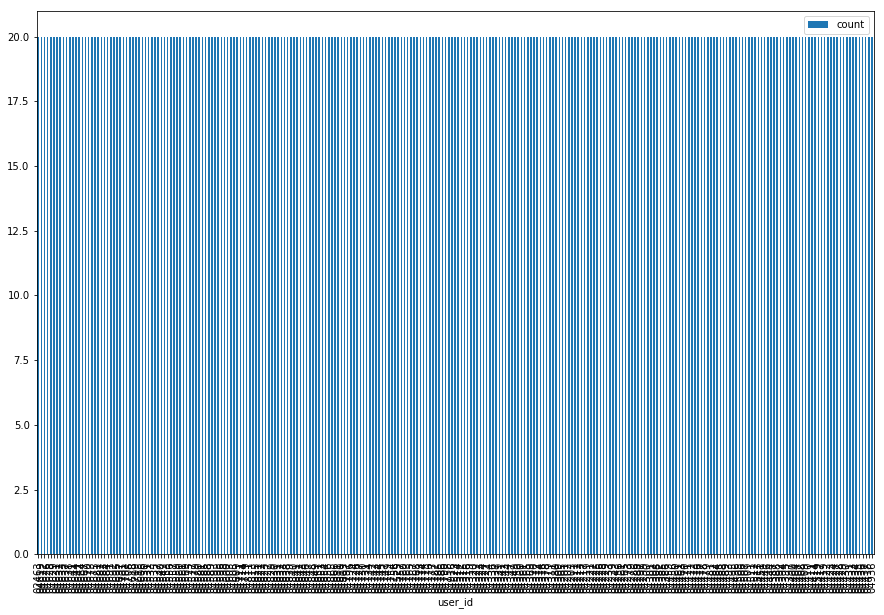

In [10]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [11]:
subset_directory_df.head()

,user_id,user_img_id,path
7394,04670,26,frgc32x32/04670d26.png
6234,04370,267,frgc32x32/04370d267.png
4576,04537,342,frgc32x32/04537d342.png
2695,04600,72,frgc32x32/04600d72.png
5842,04397,364,frgc32x32/04397d364.png


In [12]:
cat_list = [] #list of all unique labels
cat_list = subset_directory_df['user_id'].unique()

In [13]:
images = []   #list of all images
labels = []   #list of all labels on same idx as image



for index,row in subset_directory_df.iterrows():
    img = cv2.imread(row['path'], 0)
    sample = cv2.resize(img, (32,32))
    sample = np.expand_dims(img, -1)
    images.append(sample)
    labels.append(row['user_id'])

images = np.asarray(images)
labels = np.asarray(labels)
cat_list = np.asarray(cat_list)

print(images.shape, labels.shape, cat_list.shape)

(5300, 32, 32, 1) (5300,) (265,)


---

# Load and preprocess --> [train, val]

In [14]:
train_test_split = 0.7
train_size = int(len(cat_list) * train_test_split)
test_size = len(cat_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_idx = 0
while labels[train_idx+1] != cat_list[train_size]:
    train_idx += 1
train_idx += 1

img_train = images[:train_idx]
lbl_train = labels[:train_idx]
cat_train = cat_list[:train_size]

img_val = images[train_idx:]
lbl_val = labels[train_idx:]
cat_val = cat_list[train_size:]

print('X&Y shape of training data :',img_train.shape, 'and', lbl_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , img_val.shape, 'and', lbl_val.shape, cat_val.shape)

185 classes for training and 80  classes for testing
X&Y shape of training data : (343, 32, 32, 1) and (343,) (185,)
X&Y shape of testing data : (4957, 32, 32, 1) and (4957,) (80,)


---
# Build the model

In [15]:
input_shape = img_train[0].shape
print(input_shape)
left_input = Input(input_shape)
right_input = Input(input_shape)

(32, 32, 1)


In [16]:
W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

In [18]:
#Define Model

model = Sequential()
model.add(Conv2D(64, (6,6), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init))

encoded_l = model(left_input)
encoded_r = model(right_input)
          
subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(input=[left_input, right_input], output=prediction)

optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [19]:
siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 512)          1772480     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 512)          0           sequential_2[1][0]         

---
# Train

In [23]:
from tqdm.notebook import tqdm, trange

In [24]:
def get_batch(batch_size=64):
    temp_img = img_train
    temp_cat_list = cat_train
    start = 0
    end = train_size
    batch_img = []

    batch_lbl = np.zeros(batch_size)
    batch_lbl[int(batch_size/2):] = 1
#     TODO implement batches

In [25]:
siamese_net.fit(x=[xxxxx],y=xxxxxx,batch_size=64,epochs=100)



NameError: name 'xxxxx' is not defined